In [1]:
from __future__ import division
import numpy
import pandas
import matplotlib.pyplot as plt
from numpy import matrix, linalg, linspace, interp, asarray, argmax
from scipy.integrate import odeint
from scipy.stats import linregress 
%matplotlib inline
#%matplotlib notebook

## Fed-batch fermentation

As example we'll use a _Lactobacillus_ strain that is severely inhibited by high glucose concentrations. Lactic acid will be the sole excreted metabolite in the example. Let's jump in by setting up the flux model for the organism. The necessary theory will follow as we progress through the problem. The metabolic map is given below:

<img src="lacmap1.png" width="450" />

The following physiological parameters will be used:


|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$
|----|-|-|-
|$\frac{cmol\,CO_2}{cmol \, X}$|$\frac{mol \, ATP}{Cmol \, X}$|$\frac{1}{h}$|$\frac{mol \, ATP}{cmol\,X\cdot h}$
|0.05|1.8|0.4|0.09

Let's assume the standard biomass formula of $CH_{1.8}O_{0.5}N_{0.2}$.

The growth and maintenance functions are given below:

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1+\frac{C_P}{K_P} \right]^{-1} \left[1+\frac{C_S}{K_S} \right]^{-1}$$

$$\theta=\theta_{max}\left[\frac{Cs}{Km+Cs}\right]$$

Parameters are defined in the cell below:

In [2]:
Km, Kp, Ks = 0.001, 4, 0.5

In [3]:
alpha = 0.05 #cmolCO2/cmolX
gamma = 1.8 #molATP/cmolX
mumax = 0.4 #1/h
thetamax = 0.09 #molATP/cmolX/h

Let's start by plotting the glucose inhibition characteristics. Ignore the formation of product for now and plot $\mu$ as a function of $C_S$.

In [4]:
DOR = numpy.matrix([[-1, 0, 1, 1, 0],
                   [-4, 0, 4.2, 0, 2],
                   [0, -1, 0.2, 0, 0],
                   [0, 0, 1, 0, 0],
                   [0, 0, 0, 1, 0]])

C = numpy.matrix([0, 0, 0, 1, alpha]).T

DORrates = numpy.linalg.solve(DOR,C)

beta = DORrates[4,0]

beta

-8.326672684688674e-17

In [5]:
Cs = linspace(0, 7, 100)

In [6]:
mu = mumax*(1/(1 + (Cs/Ks)))#(Cs/(Km + Cs))#

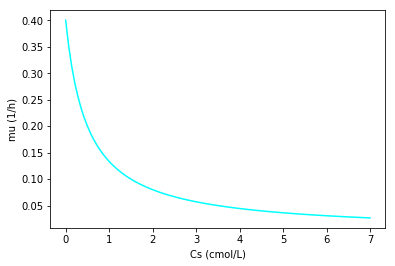

In [7]:
plt.figure(1)
plt.plot(Cs,mu, color='cyan',label='mu')
plt.ylabel('mu (1/h)') 
plt.xlabel('Cs (cmol/L)') 
plt.show()

Set up the response function and integrate a batch fermenter where $C_{Xo}$ and $C_{So}$ is given by:

In [8]:
Cxo=0.003  #cmol\L
Cso=6      #cmol/L
Claco = 0

In [9]:
def response_fun(C):
    
    Cx, Cs, Clac= C[0],C[1],C[2]  #Same component order as in the ferm-eq
    Cp = Clac
                                       
    mu1=mumax*(Cs/(Km + Cs))*((1 + (Cp/Kp))**(-1))*((1 + (Cs/Ks))**(-1))
    theta=thetamax*(Cs/(Km + Cs))
    
    if mu1 < 0.0001:   #Negative values of mu set to zero
        mu=0 
    else:
        mu=mu1
  
    Sbase = numpy.matrix([[-1,(1+alpha),1],   #Stoichiometric matrix without specification (4x5)
                          [0,(-1)*gamma,1/3]])
    
    S1 = numpy.vstack([Sbase,[0,1,0]])  #Stoich matrix with growth spec
      
    C= numpy.matrix([[0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)             
    
    return [r[1,0],   # important to see the order of the rates (X,S,LAC)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[2,0]]   # LAC

In [10]:
def ferm_eq(C,t):
    Cx, Cs, Clac= C[0],C[1],C[2] # order of components very important 
    r=response_fun([Cx, Cs, Clac])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx,    #X
            r[1]*Cx,    #glucose
            r[2]*Cx]    #LA

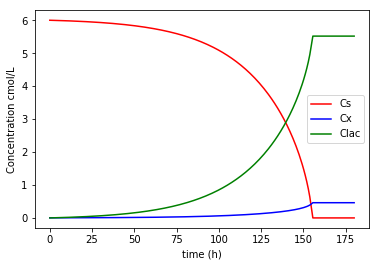

In [11]:
Co=[Cxo, Cso, Claco]                     # [Cxo, Cso, Cpo] in cmol/L
tmax=180                                    
tspan=numpy.linspace(0,tmax,200)           
Ci = odeint(ferm_eq, Co, tspan)

Cx=Ci[:,0]                                  
Cs=Ci[:,1]
Clac=Ci[:,2]

plt.figure(2)
plt.plot(tspan, Cs, color='red',label='Cs')
plt.plot(tspan, Cx, color='blue',label='Cx')
plt.plot(tspan, Clac, color='green', label='Clac')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Repeat the integration but omit the substrate inhibition term, accordingly:

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1+\frac{C_P}{K_P} \right]^{-1} $$

Compare the profiles of the two scenarios. You should get something like this:

<img src="batch_compare1.png" width="850" />


In [12]:
def response_fun1(C):
    
    Cx, Cs, Clac= C[0],C[1],C[2]  #Same component order as in the ferm-eq
    Cp = Clac
                                       
    mu1=mumax*(Cs/(Km + Cs))*((1 + (Cp/Kp))**(-1))
    theta=thetamax*(Cs/(Km + Cs))
    
    if mu1 < 0.0001:   #Negative values of mu set to zero
        mu=0 
    else:
        mu=mu1
  
    Sbase = numpy.matrix([[-1,(1+alpha),1],   #Stoichiometric matrix without specification (4x5)
                          [0,(-1)*gamma,1/3]])
    
    S1 = numpy.vstack([Sbase,[0,1,0]])  #Stoich matrix with growth spec
      
    C= numpy.matrix([[0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)             
    
    return [r[1,0],   # important to see the order of the rates (X,S,LAC)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[2,0]]   # LAC

In [13]:
def ferm_eq1(C,t):
    Cx, Cs, Clac= C[0],C[1],C[2] # order of components very important 
    r=response_fun1([Cx, Cs, Clac])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx,    #X
            r[1]*Cx,    #glucose
            r[2]*Cx]    #LA

In [14]:
Co=[Cxo, Cso, Claco]                     # [Cxo, Cso, Cpo] in cmol/L
tmax1=40

tspan1=numpy.linspace(0,tmax1,200)           
Ci1 = odeint(ferm_eq1, Co, tspan1)

Cx1=Ci1[:,0]                                  
Cs1=Ci1[:,1]
Clac1=Ci1[:,2]

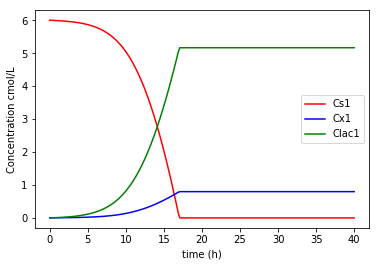

In [15]:
plt.figure(3)
plt.plot(tspan1, Cs1, color='red',label='Cs1')
plt.plot(tspan1, Cx1, color='blue',label='Cx1')
plt.plot(tspan1, Clac1, color='green', label='Clac1')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

We now want to adress the issue by gradually adding glucose to the fermenter. To do this we need to consider the original cmol component balance given in [section 5.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/5%20Basic%20bioreactor%20modeling/The%20fermenter%20equation.ipynb):

$$\frac{dN_i}{dt}=Q^F C^F_i-QC_i  + r_i C_X V $$  

Since there will be no outlet flow from the fermenter, the equation will reduce to:

$$\frac{dN_i}{dt}=Q^F C^F_i + r_i C_X V $$

Note that the superscript $^F$ is used for the feed stream. The change in fermenter volume will be given by:

$$\frac{dV}{dt}=Q^F$$

To incorporate these equations we need to alter the fermenter equation in the code. The easiest route is to integrate the cmol amounts ($N_i$) and to calculate concentration afterwards given the known cmol amounts and volume ($C_i=\frac{Ni}{V}$). The response function will remain the same and will still be described by concentrations. We will also add volume ($V$) as an additional variable to the fermenter equation in order to incorporate the volume change within the fermenter equation. Below is the incomplete fermentation equation:


In [16]:
def response_fun2(C):
    
    Cx, Cs, Clac= C[0],C[1],C[2]  #Same component order as in the ferm-eq
    Cp = Clac
                                       
    mu1=mumax*(Cs/(Km + Cs))*(1/(1 + (Cp/Kp)))*(1/(1 + (Cs/Ks)))
    theta=thetamax*(Cs/(Km + Cs))
    
    if mu1 < 0.0001:   #Negative values of mu set to zero
        mu=0 
    else:
        mu=mu1
  
    Sbase = numpy.matrix([[-1,(1+alpha),1],   #Stoichiometric matrix without specification (4x5)
                          [0,(-1)*gamma,1/3]])
    
    S1 = numpy.vstack([Sbase,[0,1,0]])  #Stoich matrix with growth spec
      
    C= numpy.matrix([[0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)             
    
    return [r[1,0],   # important to see the order of the rates (X,S,LAC)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[2,0]]   # LAC

In [17]:
def ferm_eq2(N,t):
    Cx, Cs, Clac, V = N[0]/N[3],N[1]/N[3],N[2]/N[3],N[3] # defining concentration and volume, Note that N=[Nx,Ns,Np,V]
    r=response_fun2([Cx, Cs, Clac])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx*V,    #X
            Qf*Csf + r[1]*Cx*V,    #glucose
            r[2]*Cx*V,  #lac 
            Qf]   #change in fermenter volume

Make sure you understand that $N=[N_X, N_S, N_P, V]$ is passed between the integration function (**odeint**) and the fermentation equation (**ferm_eq**). The initial condition will thus consist out of cmol amounts and volume and not just concentrations like we had in our batch fermenter models.

In the end we still want to plot concentrations. These can be obtained after the integration is completed by merely dividing with the volume at the specific instant in time:

$$C_i(t)=\frac{N_i(t)}{V(t)}$$

To test whether you understand the description above, you need to model the fed-batch fermenter on your own. You can use the following conditions:

In [18]:
V, Csf, Qf = 1000, 400/30, 8  #L, cmol/L, L/h
Cso2, Cxo2 = 0.1, 0.003          #cmol/l

In [19]:
No=[Cxo2*V, Cso2*V, Claco*V, V]                     # [Cxo, Cso, Cpo] in cmol/L
tmax2=160
tspan2=numpy.linspace(0,tmax2,500)
Ni = odeint(ferm_eq2, No, tspan2)

Cx2=Ni[:,0]/Ni[:,3]
Cs2=Ni[:,1]/Ni[:,3]
Clac2=Ni[:,2]/Ni[:,3]
V2=Ni[:,3]

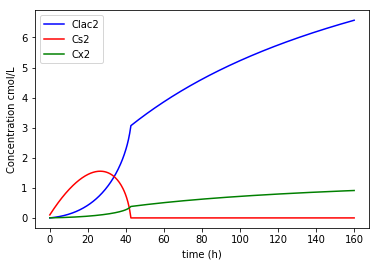

In [20]:
plt.figure(4)
plt.plot(tspan2, Clac2, color='blue', label='Clac2')
plt.plot(tspan2, Cs2, color='red',label='Cs2')
plt.plot(tspan2, Cx2, color='green',label='Cx2')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

If you calculate the volume after 120 hours you will note that the fermenter volume has almost doubled (1960 $L$). The fermentation has to stop when the fermenter is full and this will depend on the physical size of the fermenter itself. We will base the productivity of the fermenter on the final liquid volume of the fermenter. Compare the productivity of the batch and fed-batch system, by using the final product concentration in the batch fermenter as the endpoint. 

[1.07 & 1.5 $\frac{g}{L \cdot h}$] 

In [21]:
V2f = interp(120,tspan2,V2)
print('FedBatch Vfinal=',V2f, 'L')


FedBatch Vfinal= 1960.0000000000023 L


In [22]:
tdone = interp(0.001,Cs[::-1],tspan[::-1]) #on batch with all inhibition factors
tdone

155.5751297222525

In [23]:
Clacmax = max(Clac)
Clacmax

5.518409716234926

In [24]:
Pbatch = max(Clac)/tdone*30
Pbatch

1.0641308272254533

In [25]:
findClac2F = interp(tdone,tspan2,Clac2)
findClac2F #this is the Product of the fedbatch at the time the batch system stopped

6.493721774139464

In [26]:
Pfedferm = findClac2F/tdone*30
Pfedferm

1.2522030582393227

The glucose concentration against time had an interesting characteristic. There is an initial bump followed by an **almost zero** 'regime' of $C_S$. This relates to the amount of biomass in the fermenter ($C_X$) and the constant addition rate of glucose. Initially $C_X$ is not enough to consume all the added glucose and accordingly there is accumulation of glucose. As $C_X$ is increased the condition is reversed up to the point where **all glucose fed is immediately consumed**. This occurs at around 43 hours. For the remainder of the fermentation the glucose addition rate controls the growth and production of lactic acid. Play around with changing $Q^F$ and see whether the profiles make sense. Remember that high $C_S$ will inhibit $\mu$ and that the magnitude of $\mu$ determines the uptake of glucose.

Let's now plot $\mu$ as a function of time.

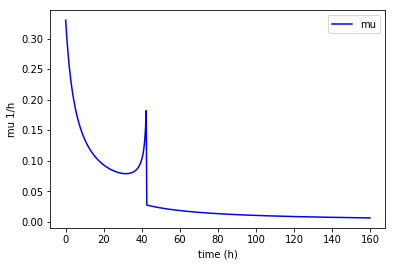

In [27]:
Ci=(Ni[:,:3].T/Ni[:,3]).T                   #first 3 elements of N divided by 4th element to get Ci, 

r=numpy.asarray([response_fun2(C) for C in Ci])

rx2=r[:,0]
rs2=r[:,1]
rlac2=r[:,2]
plt.plot(tspan2, rx2, color='blue',label='mu')
plt.legend(loc='best')
plt.ylabel('mu 1/h') 
plt.xlabel('time (h)') 
plt.show()

Interesting. In the first regime up to 43 hours $\mu$ is clearly influenced by $C_S$ where high $C_S$ gives low $\mu$ values. This is a direct influence of the $\left[1+\frac{C_S}{K_S} \right]^{-1}$ term.

In the second regime beyond 43 hours we have a scenario where the $C_S$ values are very low and accordingly the Monod term ($ \left[\frac{Cs}{Km+Cs} \right] $) has a major effect on $\mu$. Note that though $C_S$ might appear to be approaching zero, it has a magnitude that controls the value of $\mu$ that is non-zero as observed above.

Considering the glucose balance we have the following:

$$\frac{dN_S}{dt}=Q^F C^F_S + r_S C_X V $$

Determine the value of the two non-differential terms at 90 and 120 hours [106.67 and -106.67 $\frac{cmol}{h}$ for both times]

This should tell you that whatever gets added, gets consumed and that no accumulation of glucose is occurring. The chemical engineer will say that the glucose balance is at steady state. 

Convince yourself from the equation above that $r_S$ must decrease as time progress in regime 2. This will cause $\mu$ to decrease as observed above.




In [28]:
Qf


8

In [29]:
Csf

13.333333333333334

In [30]:
NDE1 = Qf*Csf   #this remains constant
NDE1

106.66666666666667

In [31]:
Cx90=interp(90,tspan2,Cx2)
Cx90

0.6728761608153633

In [32]:
Cx120=interp(120,tspan2,Cx2)
Cx120

0.7938176024179369

In [33]:
rs90=interp(90,tspan2,rs2)
rs90

-0.09216550538167537

In [34]:
rs120=interp(120,tspan2,rs2)
rs120

-0.06855728167251421

In [35]:
V90=interp(90,tspan2,V2)
V90

1720.0000000000018

In [36]:
V120=interp(120,tspan2,V2)
V120

1960.0000000000023

In [37]:
NDE2 = rs90*Cx90*V90
NDE2

-106.66747084382672

In [38]:
NDE3 = rs120*Cx120*V120
NDE3

-106.66707485251025

Therefore, we confirm that after the firt regime (43hours or so), glucose change is zero. As it is supplied, it is consumed. Also, because the 2nd non-differential term is constant, as the concentration of biomass increases and the volume increases, the rate of glucose consumption HAS to drop.

### Further improving productivity:

The issue in the fed-batch fermenter above was that we fed too much glucose initially (at low $C_X$) and too little towards the end of the fermentation (at high $C_X$). Let's consider increasing $Q^F$ as time progress. We can use the simple liner function:

$$Q^F=kt$$

Note that you will have to calculate $Q^F$ within the time dependent fermenter equation since it not a constant anymore. Use a k value of $1 \frac{L}{h^2}$ and see if you can generate the following graph:

<img src="fedbatch21.png" width="600" />


In [39]:
V3, Csf3, k = 1000, 400/30, 1  #L, cmol/L, L/h/h
Cso3, Cxo3 = 0.1, 0.003  

In [40]:
def ferm_eq3(N,t):
    Cx, Cs, Clac, V = N[0]/N[3],N[1]/N[3],N[2]/N[3],N[3] # defining concentration and volume, Note that N=[Nx,Ns,Np,V]
    r=response_fun2([Cx, Cs, Clac])      # this is the 'fetching' from the response function
    
    Qf = k*t
    
    return [r[0]*Cx*V,    #X
            Qf*Csf + r[1]*Cx*V,    #glucose
            r[2]*Cx*V,  #lac 
            Qf]   #change in fermenter volume

In [41]:
No3=[Cxo3*V3, Cso3*V3, Claco*V3, V3]                     # [Cxo, Cso, Cpo] in cmol/L
tmax3=50
tspan3=numpy.linspace(0,tmax3,500)
Ni3 = odeint(ferm_eq3, No3, tspan3)

Cx3=Ni3[:,0]/Ni3[:,3]
Cs3=Ni3[:,1]/Ni3[:,3]
Clac3=Ni3[:,2]/Ni3[:,3]
V3=Ni3[:,3]

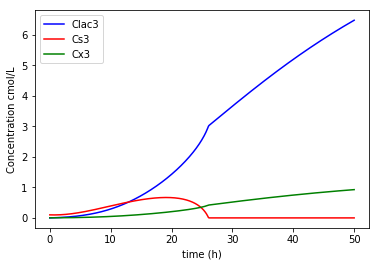

In [42]:
plt.figure(5)
plt.plot(tspan3, Clac3, color='blue', label='Clac3')
plt.plot(tspan3, Cs3, color='red',label='Cs3')
plt.plot(tspan3, Cx3, color='green',label='Cx3')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Convince yourself that the productivity at the previous $C_P$ final value is now $3.9 \frac{g}{L \cdot h}$. Much better than before, **but why?** What is the ever increasing value of  $Q^F$ doing to $\mu$ and $r_P$ in the 'second regime'?

Increase the k value to $1.2 \frac{L}{h^2}$ and see if you can get this:

<img src="fedbatch31.png" width="600" />

In [43]:
Clac2_50=interp(50,tspan2,Clac2)
Clac2_50

3.423326751412684

In [44]:
Pfedferm1 = Clac2_50/50*30 #the fed-fermentation batch at constant Qf
Pfedferm1

2.0539960508476103

In [45]:
Pfedferm3=max(Clac3)/50*30
Pfedferm3

3.887677819767313

In [46]:
#We can now see the same system with an increasing Qf has
#a P of 3.9 g/L/h at 50hours vs 2.05 g/L/H with a constant Qf
# the ever increasing Qf counteacts the monod effect on mu, although in this case not enough
#the rs consumption does not drop as quickly

In [47]:
V4, Csf4, k4 = 1000, 400/30, 1.2  #L, cmol/L, L/h/h
Cso4, Cxo4 = 0.1, 0.003  

In [48]:
def ferm_eq4(N,t):
    Cx, Cs, Clac, V = N[0]/N[3],N[1]/N[3],N[2]/N[3],N[3] # defining concentration and volume, Note that N=[Nx,Ns,Np,V]
    r=response_fun2([Cx, Cs, Clac])      # this is the 'fetching' from the response function
    
    Qf = k4*t
    
    return [r[0]*Cx*V,    #X
            Qf*Csf + r[1]*Cx*V,    #glucose
            r[2]*Cx*V,  #lac 
            Qf]   #change in fermenter volume

In [49]:
No4=[Cxo4*V4, Cso4*V4, Claco*V4, V4]                     # [Cxo, Cso, Cpo] in cmol/L
tmax4=50
tspan4=numpy.linspace(0,tmax4,500)
Ni4 = odeint(ferm_eq4, No4, tspan4)

Cx4=Ni4[:,0]/Ni4[:,3]
Cs4=Ni4[:,1]/Ni4[:,3]
Clac4=Ni4[:,2]/Ni4[:,3]
V4=Ni4[:,3]


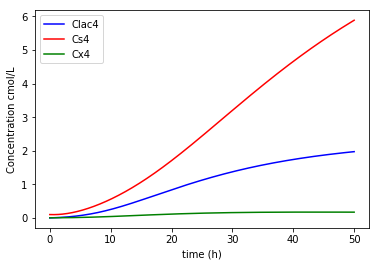

In [50]:
plt.figure(6)
plt.plot(tspan4, Clac4, color='blue', label='Clac4')
plt.plot(tspan4, Cs4, color='red',label='Cs4')
plt.plot(tspan4, Cx4, color='green',label='Cx4')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

What is happening here? It is as if the microbes are saying: "you have overstayed your welcome!". What is the mathematical cause for the unfavourable event?

By increasing the k value, it means that Qf is increasing in time at a rate that is faster than the growth of biomass and the higher concentration of glucose means the substrate inhibition coefficient now comes into effect and pushed mu down

### CBI310 higher grade (won't be asked in exam)

Given the major productivity improvement that we have obtained by adjusting the flowrate with time, the greedy bioprocess engineer will be interested in the optimum flowrate addition function. We can start by finding the $C_S$ value that will optimise $\mu$ in the function:

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1+\frac{C_S}{K_S} \right]^{-1} $$

Repeat the $\mu$ vs $C_S$ plot that we had at the beginning of the example, but choose a much smaller $C_S$ span. You will see the $C_S=0.0202 \frac{cmol}{L}$ gives the highest $\mu$. If we can operate the fermenter at this $C_S$ value we'll have the perfect balance between substrate inhibition and Monod inhibition. But how do we manipulate $Q^F$ in order to keep $C_S$ constant?  

We need to calculate $Q^{\,f}$ such that  $\frac{dC_S}{dt}=0$. If this is obeyed $C_S$ will remain at the initial value of $C_S^o$. The following manipulation can be performed to obtain the function for $Q^{\,f}$:

$$\frac{dN_S}{dt}=V\frac{dC_S}{dt}+C_S \frac{dV}{dt}  $$

$$\frac{dV}{dt}=Q^{\,f} $$

$$ \frac{dC_s}{dt}=\frac{1}{V} \left[ \frac{dN_S}{dt}-C_S Q^{\,f} \right]=0 $$

$$Q^{\,f}= \frac{1}{C_S} \frac{dN_S}{dt}=\frac{1}{C_S} \left[Q^fC_s^f+r_S C_XV \right]$$

$$Q^{\,f}= \frac{r_S C_XV}{C_S-C_S^f} $$

You now need to implement this fancy control strategy into the **fermenter equation**. If successful you will bring the productivity up to $7.5 \frac{g}{L \cdot h}$ at the $C_P^{\text{final}}$ used before.

In [51]:
Cs5 = linspace(0, 0.5, 100)

In [52]:
mu5 = mumax*(1/(1 + (Cs5/Ks)))*(Cs5/(Km + Cs5))

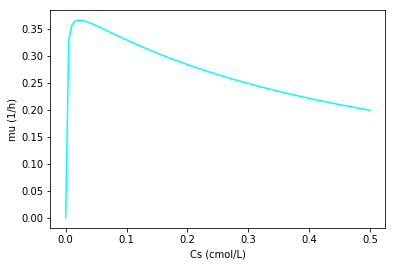

In [53]:
plt.figure(7)
plt.plot(Cs5,mu5, color='cyan',label='mu5')
plt.ylabel('mu (1/h)') 
plt.xlabel('Cs (cmol/L)') 
plt.show()

In [54]:
i = argmax(mu5==max(mu5))
Cs5_opt = Cs5[i]
Cs5_opt

0.020202020202020204

In [126]:
V5, Csf5= 1000, 400/30  #L, cmol/L
Cso5, Cxo5 = Cs5_opt, 0.003          #cmol/l 0.1

In [127]:
def ferm_eq5(N,t):
    Cx, Cs, Clac, V = N[0]/N[3],N[1]/N[3],N[2]/N[3],N[3] # defining concentration and volume, Note that N=[Nx,Ns,Np,V]
    r=response_fun2([Cx, Cs, Clac])      # this is the 'fetching' from the response function
    
    Qf = r[1]*Cx*V/(Cs-Csf5)
    
    return [r[0]*Cx*V,    #X
            Qf*Csf5 + r[1]*Cx*V,    #glucose
            r[2]*Cx*V,  #lac 
            Qf]   #change in fermenter volume

In [128]:
No5=[Cxo5*V5, Cso5*V5, Claco*V5, V5]                     # [Cxo, Cso, Cpo] in cmol/L
tmax5=50
tspan5=numpy.linspace(0,tmax5,500)
Ni5 = odeint(ferm_eq5, No5, tspan5)

Cx5=Ni5[:,0]/Ni5[:,3]
Cs5=Ni5[:,1]/Ni5[:,3]
Clac5=Ni5[:,2]/Ni5[:,3]
V5=Ni5[:,3]

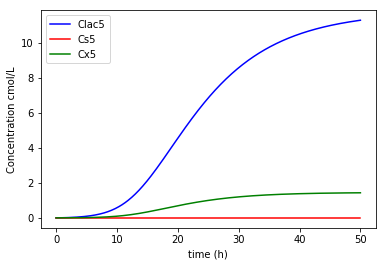

In [129]:
plt.figure(8)
plt.plot(tspan5, Clac5, color='blue', label='Clac5')
plt.plot(tspan5, Cs5, color='red',label='Cs5')
plt.plot(tspan5, Cx5, color='green',label='Cx5')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

In [130]:
Clac3[-1] # where last Cp was run to 50hours


6.479463032945522

In [131]:
t_compare = interp(Clac3[-1],Clac5,tspan5) #getting time where same Cp was reached
t_compare

24.1318726206763

In [132]:
Productivity = Clac3[-1]/t_compare*30
Productivity

8.055068665571218